## Load Packages

In [1]:
import geopandas as gpd
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D,ParticleFile,ErrorCode,AdvectionRK4, Variable,VectorField,Field, FieldSamplingError
import pandas as pd
from scipy import interpolate
from glob import glob
import numpy as np
from datetime import date,timedelta
import datetime
import xarray as xr
import pytz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import imageio
import matplotlib.font_manager as fm
import math

# Geting the Files

In [2]:
OP_output  = '/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/simple_run.nc'
OP_nc      = xr.open_dataset(OP_output)

## Hydrodynamics
Hydro_file = '/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/Data/gbr1_simple_2014-12-01.nc'
hydro_nc = xr.open_dataset(Hydro_file)
latitudes = hydro_nc['latitude']
longitudes = hydro_nc['longitude']

## Interpolation
- In this step I subset the hydro model to the points closer to the particle location
- Tnhis step is mainly to avoid to overload the interpolation

In [3]:
def subset_hydromodel(latitudes, longitudes, lat_prtcl, lon_prtcl, variable):
    ## Subset of the hydromodel
    latmin = lat_prtcl - 0.04
    latmax = lat_prtcl + 0.04
    lonmin = lon_prtcl - 0.02
    lonmax = lon_prtcl + 0.02
    # getting index for lat and lon
    diff_max = np.abs(latmax - latitudes) + np.abs(lonmax - longitudes)
    diff_min = np.abs(latmin - latitudes) + np.abs(lonmin - longitudes)
    latlon_max = np.where(diff_max == diff_max.min())
    latlon_min = np.where(diff_min == diff_min.min())
    latmin = latlon_min[0].item(); lonmin = latlon_min[1].item()
    latmax = latlon_max[0].item(); lonmax = latlon_max[1].item()
    ## lat and lons for the selected area
    subset_lons  = longitudes[latmin : latmax, lonmin : lonmax]
    subset_lats  = latitudes[latmin : latmax, lonmin : lonmax]
    subset_var   = variable[latmin : latmax, lonmin : lonmax]
    return(subset_lats, subset_lons, subset_var)



## Particle values
- Reading the values from the OceanParcel Outputs
- I do the transformation from deg/s to m/s
- I deviden the values for 3600 to get the values in seconds

In [4]:
cos_vec = np.vectorize(math.cos)
dg2m  = 1852*60
prtcl = 2 ## number of the particle
prt_lat  = OP_nc['lat'][prtcl,].squeeze()
prt_lon  = OP_nc['lon'][prtcl,]
prt_time = OP_nc['time'][prtcl,]
prt_V   = OP_nc['V_effective'][prtcl,] 
prt_V_m = prt_V * dg2m / 3600
prt_U   = OP_nc['U_effective'][prtcl,]
prt_U_m = prt_U * dg2m * cos_vec((prt_lat*math.pi/180)) / 3600


## This output will create a gif with the velocity field from GBR1 in the background


In [5]:
layer = 39 ## layer at -5.35
hydro_interp_u =  [0]*25
hydro_interp_v =  [0]*25
for time_step in range(0, 24): # number of time steps in the output (delta_time=1hour)
    U = hydro_nc['u'][time_step, layer]
    V = hydro_nc['v'][time_step, layer]
    [subset_lats_U, subset_lons_U, subset_var_U] = subset_hydromodel(latitudes, longitudes, prt_lat[time_step], prt_lon[time_step], U)
    [subset_lats_V, subset_lons_V, subset_var_V] = subset_hydromodel(latitudes, longitudes, prt_lat[time_step], prt_lon[time_step], V)
    # creating the interpolation function
    f_u = interpolate.interp2d(subset_lons_U, subset_lats_U, subset_var_U, kind = 'cubic')
    f_v = interpolate.interp2d(subset_lons_V, subset_lats_V, subset_var_V, kind = 'cubic')
    ## interplating the values
    hydro_interp_u[time_step] = f_u(prt_lon[time_step], prt_lat[time_step]).item()
    hydro_interp_v[time_step] = f_v(prt_lon[time_step], prt_lat[time_step]).item()
    
    ## creating figure
    fig = plt.figure(figsize=(10,10), facecolor='silver', constrained_layout=True)
    gs = gridspec.GridSpec(ncols=1, nrows=1, width_ratios=[1], figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_ylabel('Latitude [degrees]')
    ax1.set_xlabel('Longitude [degrees]')
    ax1.set_xlim(146.15, 146.29)
    ax1.set_ylim(-16.94, -16.81)
    #lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax]
    quiv = ax1.quiver(subset_lons_U,subset_lats_U,subset_var_U,subset_var_V,color='lavender', scale = 2, width=0.005)
    ## Point Particle
    quiv2=ax1.quiver(prt_lon[time_step], prt_lat[time_step], prt_U_m[time_step], prt_V_m[time_step], color='salmon', scale=2,width=0.005)
    ## Hydro interpolated
    quiv3=ax1.quiver(prt_lon[time_step], prt_lat[time_step], hydro_interp_u[time_step], hydro_interp_v[time_step], color='royalblue', scale=2,width=0.005)
   
    ax1.set_title('Particle time ' + str(time_step * 3600), fontsize=14, fontweight = 'bold')
    ax1.quiverkey(quiv, 0.82, 0.9, 0.1, 'GBR1 Hydro velocity field', coordinates='axes')
    ax1.quiverkey(quiv2, 0.82, 0.82, 0.1, 'OceanParcels velocity at paricle location', coordinates='axes')
    ax1.quiverkey(quiv3, 0.82, 0.74, 0.1, 'GBR1 Hydro velocity at particle location', coordinates='axes')
    plt.savefig('Figures/{}.png'.format(time_step))
    plt.close()
        
images = []
for time_step in range(0, 24):
    filename = 'Figures/'+ str(time_step) + '.png'
    images.append(imageio.v2.imread(filename))
    imageio.mimsave('Velocity_field_at_particle.gif', images, duration=2)

/home/por07g/miniconda3/envs/salish_sea_env/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=10,12 m=45 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/por07g/miniconda3/envs/salish_sea_env/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=11,11 m=45 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/por07g/miniconda3/envs/salish_sea_env/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: 

## Image with the velocity fiel at the particle location

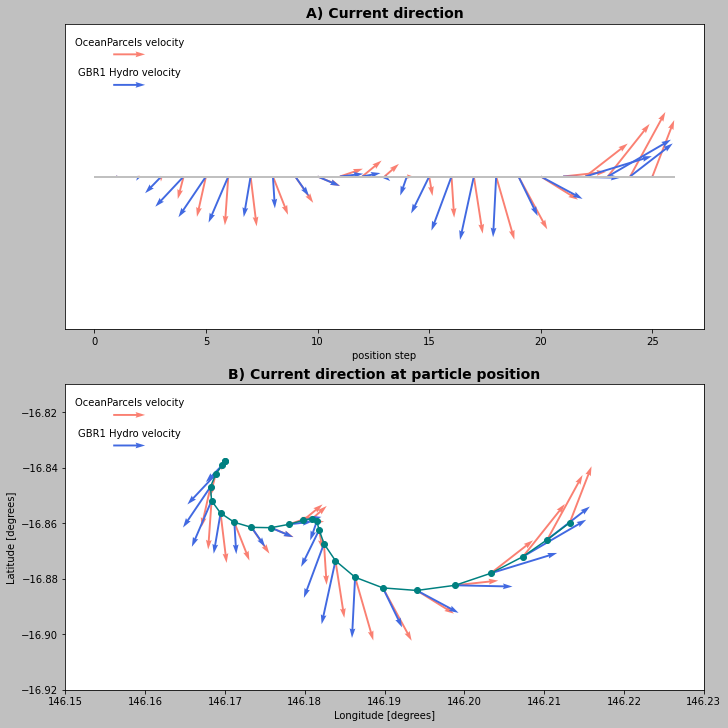

In [7]:
fig = plt.figure(figsize=(10,10), facecolor='silver', constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=2, width_ratios=[1], figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylim(-0.02, 0.02)
ax0.set_ylabel('')
ax0.set_xlabel('position step')
ax0.axes.get_yaxis().set_visible(False)
ax0.set_title('A) Current direction', fontsize=14, fontweight = 'bold')
## lineal plot
y = [0]*25
x = range(1,26)
ax0.hlines(y=0, xmin=0, xmax=26, colors='silver', linestyles='-', lw=2)
q1=ax0.quiver(x, y, prt_U_m, prt_V_m, color='salmon', scale=2,width=0.003)
## Hydro interpolated
q2=ax0.quiver(x, y, hydro_interp_u, hydro_interp_v, color='royalblue', scale=2,width=0.003)
ax0.quiverkey(q1, 0.1, 0.9, 0.1, 'OceanParcels velocity', coordinates='axes')
ax0.quiverkey(q2, 0.1, 0.8, 0.1, 'GBR1 Hydro velocity', coordinates='axes')
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title('B) Current direction at particle position', fontsize=14, fontweight = 'bold')
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_xlim(146.15, 146.23)
ax1.set_ylim(-16.92, -16.81)
## Point Particle
ax1.plot(prt_lon, prt_lat, color='teal',marker='o')
q3=ax1.quiver(prt_lon, prt_lat, prt_U_m, prt_V_m, color='salmon', scale=2,width=0.003)
## Hydro interpolated
q4=ax1.quiver(prt_lon, prt_lat, hydro_interp_u, hydro_interp_v, color='royalblue', scale=2,width=0.003)
ax1.quiverkey(q3, 0.1, 0.9, 0.1, 'OceanParcels velocity', coordinates='axes')
ax1.quiverkey(q4, 0.1, 0.8, 0.1, 'GBR1 Hydro velocity', coordinates='axes')

plt.savefig('Figures/Particle_velocities_at_location.png')
#plt.close()


